## ORIE 6750 Homework 2 Question 1 and 2

Yujia Zhang yz685@cornell.edu

For two different sets of $(f_0,f_1)$ (Bernoulli and normal), we first compute the Q-factors and value functions in the finite horizon setting with $H=20$; then we use the optimal policy computed for $H=20$ in an infinite-horizon setting with $p_0=0.5$, estimate its expected loss over 1000 trials, and compare this value to $V(0.5,H)$, i.e. the finite-horizon setting with the same starting value $p=0.5$.

In [86]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.integrate as integrate

### a) $f_0$ is Ber(1/2), $f_1$ is Ber(2/3).

In [248]:
# set up parameters and initialize

M=1000
H=20
delta = 1/M
c=0.05

Q_stop = np.zeros([M+1])
Q_go = np.zeros([H+1, M+1])
V = np.zeros([H+1, M+1])


In [249]:
# perform Bellman iteration

for i in range(M+1):
    Q_stop[i] = np.amin([i*delta, 1-i*delta])
V[0,:] = Q_stop

for h in range(1, H+1):
    for i in range(M+1):
        p = i*delta
        ind1 = np.floor((4*p*M)/(p+3))
        ind2 = np.floor((2*p*M)/(3-p))
        Q_go[h, i] = c+(1/2+1/6*p)*V[h-1, int(ind1)] + (1/2-1/6*p)*V[h-1, int(ind2)]
    V[h,:] = np.minimum(V[0,:], Q_go[h,:])

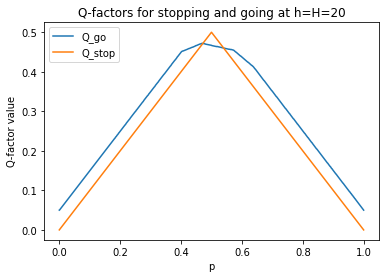

In [250]:
# plot Q-factors for stopping and going at H=20

xticks = np.linspace(0,1,M+1)
plt.plot(xticks, Q_go[20,:], label='Q_go')
plt.plot(xticks, V[0,:], label='Q_stop')
plt.legend(loc = 'upper left')
plt.title('Q-factors for stopping and going at h=H=20')
plt.xlabel('p')
plt.ylabel('Q-factor value')
plt.show()

In [260]:
# Find the region (a,b) where the optimal policy wants to keep sampling

goleft = delta * np.where(V[20,:]-Q_stop<0)[0][0]
goright = delta * np.where(V[20,:]-Q_stop<0)[0][-1]
print([goleft, goright])

[0.47200000000000003, 0.539]


In [261]:
# Now apply this policy infinite-horizon problem to compute expected loss

p0 = 0.5
c=0.05
a=goleft
b=goright
Nsim = 1000
cumulativeLoss = 0
Ls = []
Nsamples = []

In [262]:
# simulate over 1000 trials

for j in range(Nsim):
    L=0
    p=p0
    i=1
    keepgoing = True
    theta=np.random.binomial(1,p0)
    thetahat = 0
    
    mu = 1/2 if theta==0 else 2/3

    while keepgoing:
        y = np.random.binomial(1,mu)
        L = L+c
        if y==1:
            p = 4*p/(p+3)
        else:
            p = 2*p/(3-p)
        
        if p>a and p<b:
            i=i+1
        else:
            keepgoing = False
            thetahat = 0 if p<0.5 else 1

    penalty = 0 if thetahat == theta else 1
    L = L + penalty
    Ls.append(L)
    Nsamples.append(i)
    
    cumulativeLoss = cumulativeLoss + L

In [263]:
# compute expected loss and conf interval; compare to V(0.5,H) in finite-horizon setting

conf = np.std(np.array(Ls))/np.sqrt(Nsim)

print('Expected loss: ' + str(cumulativeLoss/Nsim))
print('V(0.5,H): ' + str(V[-1,int(M/2+1)]))
print('1-SD Confidence interval: ' + str([cumulativeLoss/Nsim-conf, cumulativeLoss/Nsim+conf]))
print('Mean and SD of number of samples: ' + str([np.mean(Nsamples), np.std(Nsamples)]))

Expected loss: 0.47000000000000774
V(0.5,H): 0.4663379999999999
1-SD Confidence interval: [0.4543923095879064, 0.4856076904121091]
Mean and SD of number of samples: [1.0, 0.0]


Text(0.5, 1.0, 'Distribution of number of samples required for inf-horizon problem')

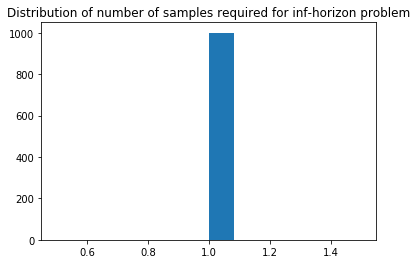

In [255]:
# How many samples were taken on avg before stopping?

np.mean(Nsamples)
np.std(Nsamples)
plt.hist(Nsamples, bins=12)
plt.title('Distribution of number of samples required for inf-horizon problem')

### b) $f_0$ is Normal(0,1), $f_1$ is Normal(1,1)

$Q(p,h,\text{go})=c+\sum_{j=0}^M V\left[j,h-1 \right] \int_{y_{lower}(j)}^{y_{upper}(j)} \frac{1}{\sqrt{2\pi}}\left(pe^{-(y-1)^2/2}+(1-p)e^{-y^2/2}\right)dy$

In [155]:
# set up parameters and initialize

M=100
H=20
delta = 1/M
c=0.05

Q_stop = np.zeros([M+1])
Q_go = np.zeros([H+1, M+1])
V = np.zeros([H+1, M+1])


In [156]:
# perform Bellman iteration

for i in range(M+1):
    Q_stop[i] = np.amin([i*delta, 1-i*delta])
V[0,:] = Q_stop

littleq = lambda x, p: p*np.exp(-(x-1)**2/2) + (1-p)*np.exp(-x**2/2)

for h in range(1, H+1):
    
    for i in range(1,M):
        p = i*delta
        
        for j in range(1, M-1):
            # NaN and inf values at the two extremes of y. Solution: truncate j.
            ylower = 0.5 + np.log((1-p)/p) - np.log(1/(j*delta)-1)
            yupper = 0.5 + np.log((1-p)/p) - np.log(1/((j+1)*delta)-1)
            #print([i, ylower,yupper]) 
            
            q = integrate.quad(littleq, ylower, yupper, args=(p,))[0]
            #print([h,i,j,q])
            Q_go[h,i] = Q_go[h,i] + V[h-1,j]*q*1/(np.sqrt(2*np.pi))
            #print([h,i,j,Q_go[h,i]])
        
        Q_go[h,i] = Q_go[h,i]+c
        
    V[h,:] = np.minimum(V[0,:], Q_go[h,:])

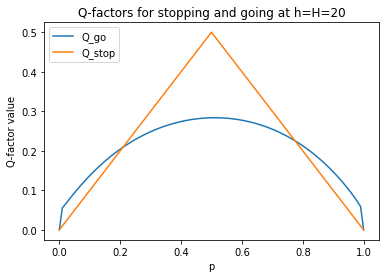

In [157]:
# plot Q-factors for stopping and going at H=20

xticks = np.linspace(0,1,M+1)
plt.plot(xticks, Q_go[20,:], label='Q_go')
plt.plot(xticks, V[0,:], label='Q_stop')
plt.legend(loc = 'upper left')
plt.title('Q-factors for stopping and going at h=H=20')
plt.xlabel('p')
plt.ylabel('Q-factor value')
plt.show()

In [166]:
# Find the region (a,b) where the optimal policy wants to keep sampling

goleft = delta * np.where(V[20,:]-Q_stop<0)[0][0]
goright = delta * np.where(V[20,:]-Q_stop<0)[0][-1]
print([goleft, goright])

[0.21, 0.77]


In [225]:
# Now apply this policy infinite-horizon problem to compute expected loss

p0 = 0.5
i=1
L=0
c=0.05
a=goleft
b=goright
Nsim = 1000
cumulativeLoss = 0
Ls = []
Nsamples = []

In [226]:
# simulate over 1000 trials

for j in range(Nsim):
    L=0
    p=p0
    i=1
    keepgoing = True
    theta=np.random.binomial(1,p0)
    thetahat = 0
    
    if theta==0:
        mu, sigma = 0,1
    else:
        mu,sigma = 1,1

    while keepgoing:
        y = np.random.normal(mu, sigma, 1)
        L = L+c
        p = p/(p+(1-p)*np.exp(-y+0.5))
        if p>a and p<b:
            i=i+1
        else:
            keepgoing = False
            thetahat = 0 if p<0.5 else 1

    penalty = 0 if thetahat == theta else 1
    L = L + penalty
    Ls.append(L)
    Nsamples.append(i)
    
    cumulativeLoss = cumulativeLoss + L

In [231]:
# compute expected loss and conf interval; compare to V(0.5,H) in finite-horizon setting

conf = np.std(np.array(Ls))/np.sqrt(Nsim)

print('Expected loss: ' + str(cumulativeLoss/Nsim))
print('V(0.5,H): ' + str(V[-1,51]))
print('1-SD Confidence interval: ' + str([cumulativeLoss/Nsim-conf, cumulativeLoss/Nsim+conf]))
print('Mean and SD of number of samples: ' + str([np.mean(Nsamples), np.std(Nsamples)]))

Expected loss: 0.285500000000001
V(0.5,H): 0.28373679781283584
1-SD Confidence interval: [0.27416599144168413, 0.2968340085583178]
Mean and SD of number of samples: [2.99, 2.0119393629033655]


Text(0.5, 1.0, 'Distribution of number of samples required for inf-horizon problem')

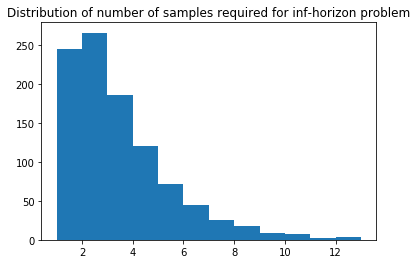

In [236]:
# How many samples were taken on avg before stopping?

np.mean(Nsamples)
np.std(Nsamples)
plt.hist(Nsamples, bins=12)
plt.title('Distribution of number of samples required for inf-horizon problem')